In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from network.models.building_blocks.resnet import resnet34
from network.coil_model import CoILModel
from input.coil_dataset import CoILDataset
from torch.autograd import Variable
from configs.coil_global import _g_conf
from ipywidgets import interact
from IPython import display
from scipy.misc import imresize
import time
import torch

In [3]:
_g_conf.TRAIN_DATASET_NAME = 'CARLA100'

In [4]:
MODEL_TYPE='coil-icra'
MODEL_CONFIGURATION = {  # good place to check integrity. All sizes should match
  "perception": {
    "res": {
      "name": 'resnet34',
      "num_classes": 512
    }
  },
  "measurements": {
    "fc": {
      "neurons": [128, 128],
      "dropouts": [0.0, 0.5]
    }
  },
  "join": {
    "fc": {
      "neurons": [512],
      "dropouts": [0.0]
    }
  },
  "speed_branch": {
    "fc": {
      "neurons": [256, 256],
      "dropouts": [0.5, 0.5]
    }
  },
  "branches": {
    "number_of_branches": 4,
    "fc": {
      "neurons": [256, 256],
      "dropouts": [0.5, 0.5]
    }
  }
}

In [5]:
dataset = CoILDataset('/mnt/local/', None, '1hour_train')
model = CoILModel(MODEL_TYPE, MODEL_CONFIGURATION)

 Loading from NPY 
['episode_00000/CentralRGB_00000.png' 'episode_00000/LeftRGB_00000.png'
 'episode_00000/RightRGB_00000.png' ...
 'episode_00005/CentralRGB_02161.png' 'episode_00005/LeftRGB_02161.png'
 'episode_00005/RightRGB_02161.png']


In [6]:
ckpt = torch.load('100000.pth')
model.load_state_dict(ckpt['state_dict'])
model.eval()

CoILICRA(
  (perception): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [7]:
def forward(self, x):
    print (x.shape)
    x = self.conv1(x)
    print ('conv1', x.shape)
    x = self.bn1(x)
    x = self.relu(x)
    print (x.shape)
    x = self.maxpool(x)
    print (x.shape)

    x1 = self.layer1(x)
    print ('layer1', x1.shape)
    x2 = self.layer2(x1)
    print ('layer2', x2.shape)
    x3 = self.layer3(x2)
    print ('layer3', x3.shape)
    x4 = self.layer4(x3)
    print ('layer4', x4.shape)

    x5 = self.avgpool(x4)
    print ('layer5', x5.shape)
    x = x5.view(x.size(0), -1)
    print ('layer6', x.shape)
    x = self.fc(x)
    print ('layer7', x.shape)


    return x, x1, x2, x3, x4, x5

/mnt/local/CARLA100/episode_00000/CentralRGB_00000.png


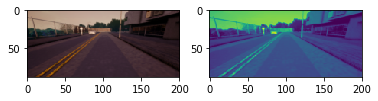

In [8]:
fig, (ax1, ax2) = subplots(1, 2)

img = dataset[0]['rgb'].cpu().numpy().transpose(1, 2, 0)[:, :, ::-1]
p1 = ax1.imshow(img)
p2 = ax2.imshow(img[:, :, 0])

In [9]:
def make_image(index):
    img = dataset[index]['rgb']
    X = Variable(img.unsqueeze(0))
    #p1.set_data(img.cpu().numpy().transpose(1, 2, 0)[:, :, ::-1])
    p1.set_data(img.cpu().numpy().transpose(1, 2, 0)[:, :, ::-1])
    
    Y = forward(model.perception, X)
    att = torch.abs(Y[1]).sum(1)[0].data.cpu().numpy()
    att = imresize(att, [88, 200])
    # p2.set_data(att)
    p2.set_data(att)
    p2.set_clim(att.min(), att.max())
    display.clear_output(wait=True)
    figsize(10, 10)
    # display.display(fig)
    return fig

_ = interact(make_image, index=(0, len(dataset)-1))


interactive(children=(IntSlider(value=18914, description='index', max=37829), Output()), _dom_classes=('widget…